In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
# Define the folder containing the data files
data_folder = 'web-clicks-nov-2009'

# Initialize an empty list to hold the DataFrames
data_frames = []

# Initialize a list to hold the statistics for each day
click_stats = []

# Loop through the range of dates
for day in range(1, 23):
    # Construct the file name
    file_name = f'2009-11-{day:02d}.json'
    # Construct the full file path
    file_path = os.path.join(data_folder, file_name)
    # Read the JSON file into a DataFrame
    df = pd.read_json(file_path, lines=True)
    
    # Filter out rows with empty "from" or "to" domains
    df = df[df['from'] != '']
    df = df[df['to'] != '']
    
    # Calculate max, min number of clicks, row count, and total clicks for the day
    max_clicks = df['count'].max()
    min_clicks = df['count'].min()
    row_count = len(df)
    total_clicks = df['count'].sum()
    
    click_stats.append({
        'date': file_name,
        'max_clicks': max_clicks,
        'min_clicks': min_clicks,
        'row_count': row_count,
        'total_clicks': total_clicks
    })
    
    # Append the DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

# Convert click_stats to a DataFrame for better display
click_stats_df = pd.DataFrame(click_stats)

# Temporal Analysis
all_data['timestamp'] = pd.to_datetime(all_data['timestamp'], unit='s')
all_data['date'] = all_data['timestamp'].dt.date
all_data['hour'] = all_data['timestamp'].dt.hour
all_data['day_of_week'] = all_data['timestamp'].dt.day_name()

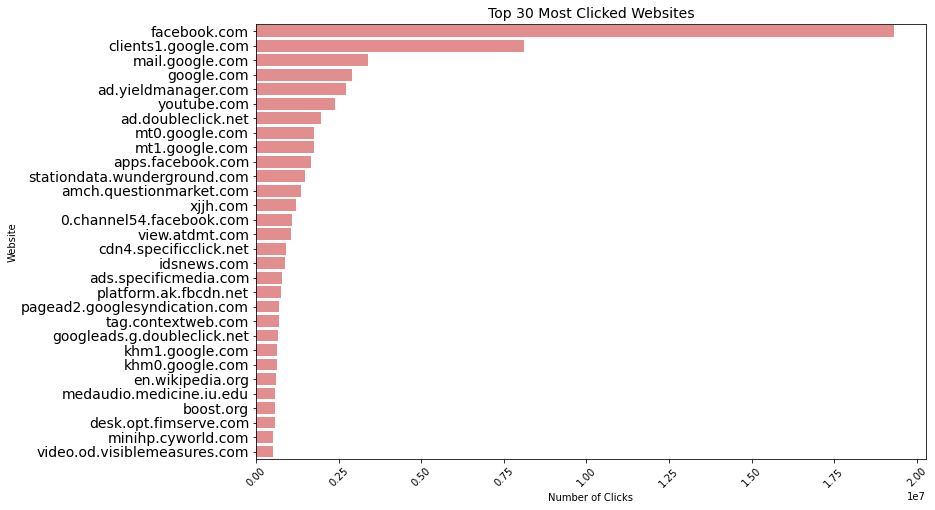

In [3]:
# Aggregate clicks by destination
clicks_by_website = all_data.groupby('to')['count'].sum().reset_index()

# Sort by the number of clicks
top_websites = clicks_by_website.sort_values(by='count', ascending=False).head(30)

# Plot the 20 most clicked websites
plt.figure(figsize=(12, 8))
sns.barplot(data=top_websites, x='count', y='to', color='lightcoral')
plt.title('Top 30 Most Clicked Websites', fontsize=14)
plt.xlabel('Number of Clicks')
plt.ylabel('Website')
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.show()

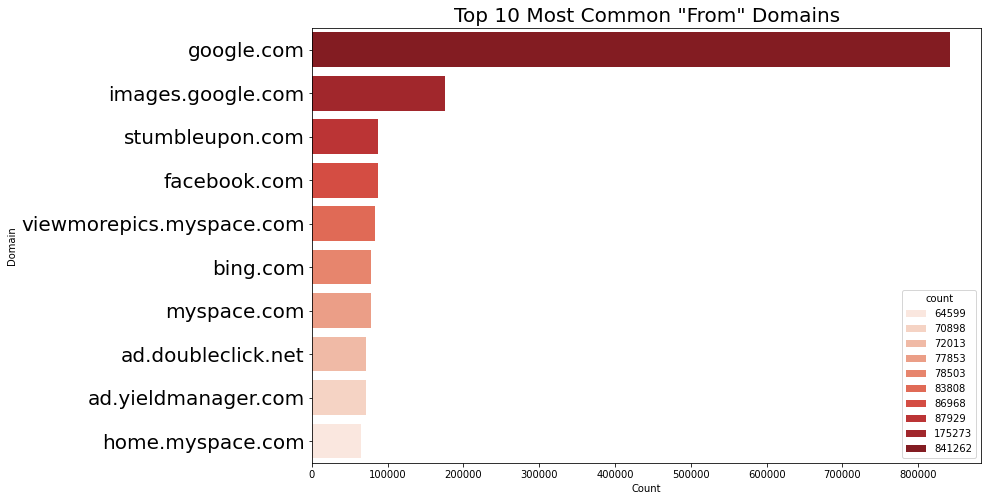

In [4]:
# Calculate the top 10 most common "from" domains
top_from_domains = all_data['from'].value_counts().head(10).reset_index()
top_from_domains.columns = ['domain', 'count']

# Plotting the top 10 most common "from" domains
plt.figure(figsize=(12, 8))
sns.barplot(data=top_from_domains, x='count', y='domain', hue='count', palette=sns.color_palette('Reds', n_colors=10))
plt.title('Top 10 Most Common "From" Domains', fontsize=20)
plt.xlabel('Count')
plt.ylabel('Domain')
plt.yticks(fontsize=20)
plt.show()

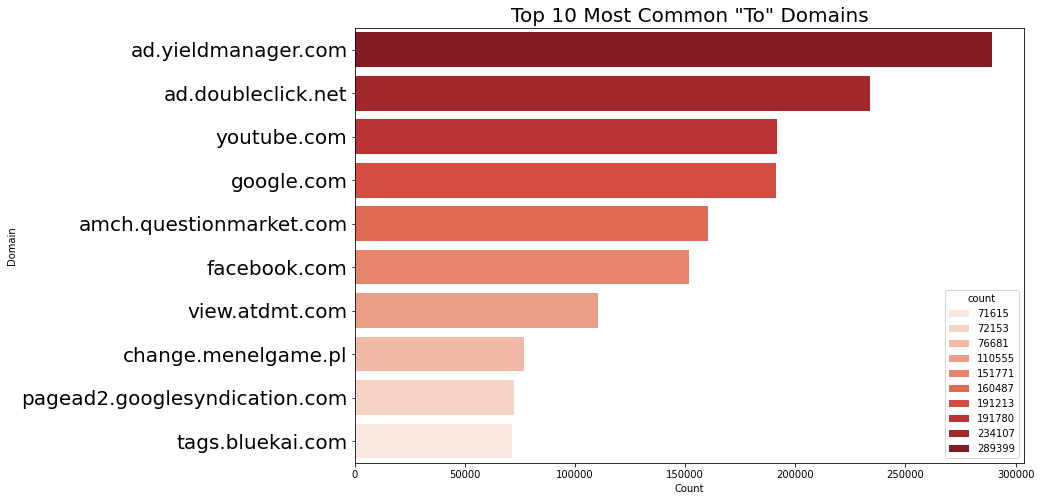

In [5]:
# Calculate the top 10 most common "to" domains
top_to_domains = all_data['to'].value_counts().head(10).reset_index()
top_to_domains.columns = ['domain', 'count']

# Plotting the top 10 most common "to" domains
plt.figure(figsize=(12, 8))
sns.barplot(data=top_to_domains, x='count', y='domain', hue='count', palette=sns.color_palette('Reds', n_colors=10))
plt.title('Top 10 Most Common "To" Domains', fontsize=20)
plt.xlabel('Count')
plt.ylabel('Domain')
plt.yticks(fontsize=20)
plt.show()

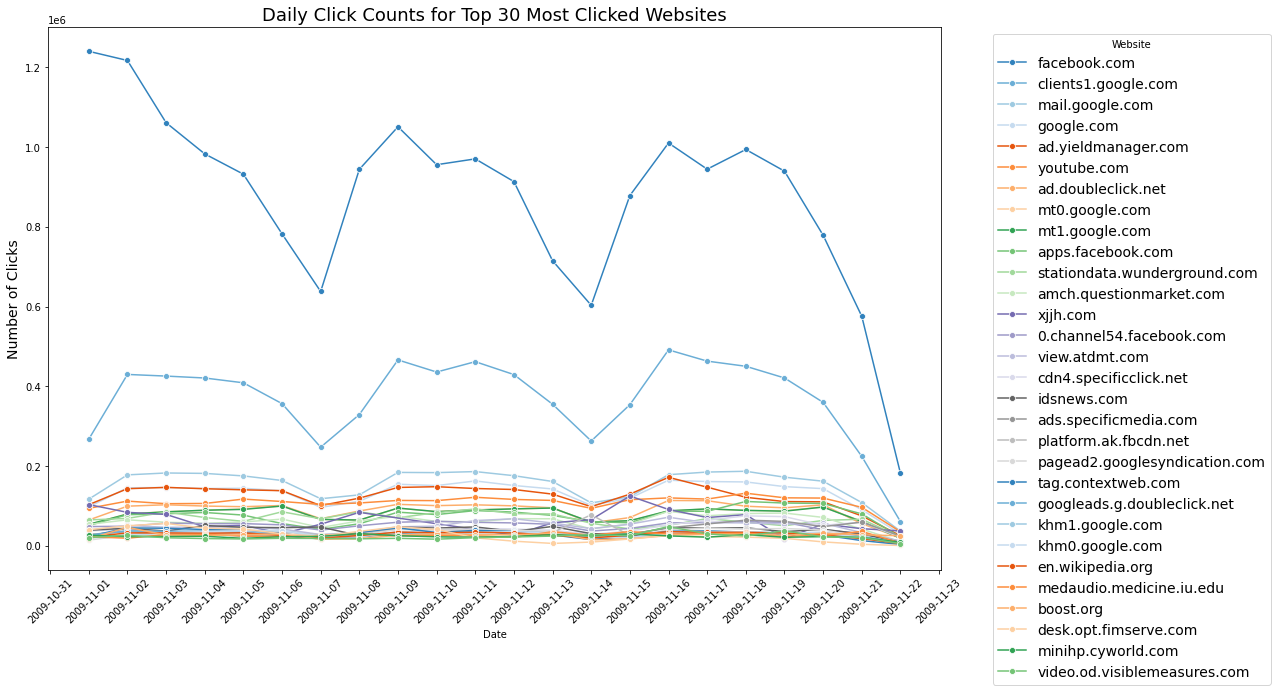

In [6]:
# Sort by the number of clicks
top_30_websites = clicks_by_website.sort_values(by='count', ascending=False).head(30)

# Filter the data for the top 30 websites
top_30_data = all_data[all_data['to'].isin(top_30_websites['to'])].copy()

# Convert the timestamp to date format for daily aggregation
top_30_data.loc[:, 'date'] = pd.to_datetime(top_30_data['timestamp'], unit='s').dt.date

# Aggregate clicks by destination and date
daily_clicks = top_30_data.groupby(['date', 'to'])['count'].sum().reset_index()

# Step 1: Aggregate clicks by destination and sort by total clicks
sorted_websites = top_30_data.groupby('to')['count'].sum().sort_values(ascending=False).index

# Step 2: Plot the daily click counts for each of the top 30 websites
plt.figure(figsize=(16, 10))
sns.lineplot(data=daily_clicks, x='date', y='count', hue='to', hue_order=sorted_websites, palette='tab20c', marker='o')

plt.title('Daily Click Counts for Top 30 Most Clicked Websites', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Number of Clicks', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Website', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()

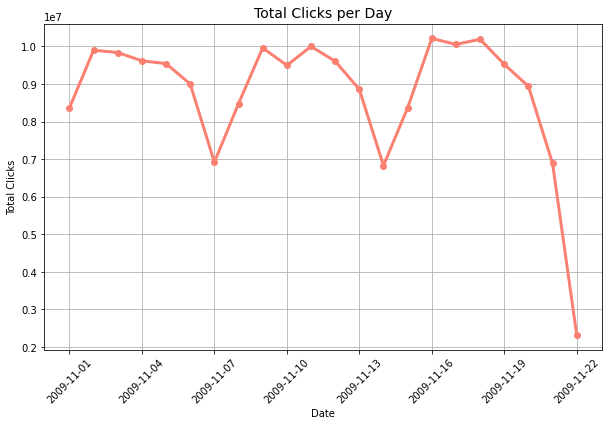

In [7]:
# Aggregate total clicks per day
daily_clicks = all_data.groupby('date')['count'].sum()

# Generate a date range with a frequency of 7 days for x-axis ticks
date_range = pd.date_range(start=daily_clicks.index.min(), end=daily_clicks.index.max(), freq='3D')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_clicks.index, daily_clicks.values, color='salmon', linewidth=3, marker='o')
plt.title('Total Clicks per Day', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.grid(True)

# Set x-axis ticks and labels
plt.xticks(date_range, rotation=45)
plt.show()

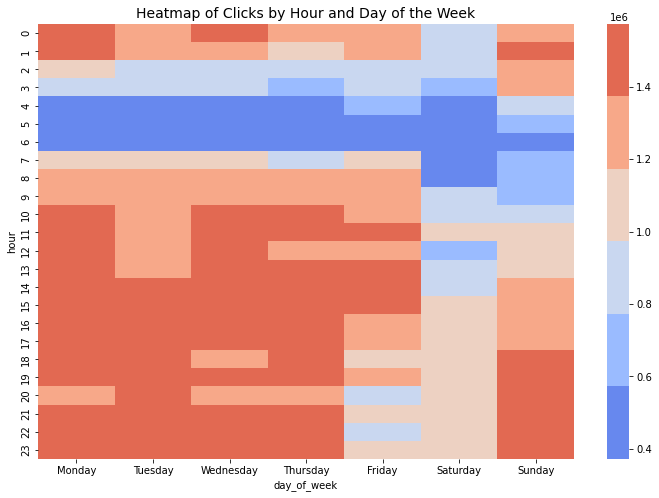

In [8]:
import seaborn as sns

# Prepare heatmap data
heatmap_data = all_data.pivot_table(values='count', index='hour', columns='day_of_week', aggfunc='sum')
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Plot heatmap with "rocket" color palette
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap=sns.color_palette('coolwarm'), annot=False, fmt='d')
plt.title('Heatmap of Clicks by Hour and Day of the Week', fontsize=14)
plt.show()


In [9]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Reshape the data for ANOVA
long_format_data = heatmap_data.reset_index().melt(id_vars=['hour'], var_name='day_of_week', value_name='clicks')

# Perform Two-Way ANOVA
model = ols('clicks ~ C(hour) + C(day_of_week) + C(hour):C(day_of_week)', data=long_format_data).fit()
anova_results = anova_lm(model)

print(anova_results)

                           df        sum_sq       mean_sq    F  PR(>F)
C(hour)                  23.0  1.271926e+13  5.530111e+11  0.0     NaN
C(day_of_week)            6.0  2.685956e+12  4.476593e+11  0.0     NaN
C(hour):C(day_of_week)  138.0  3.191203e+12  2.312466e+10  0.0     NaN
Residual                  0.0  6.211191e-16           inf  NaN     NaN


e:\Coding Tools\Python 3.9.2\lib\site-packages\statsmodels\stats\anova.py:142: RuntimeWarning: divide by zero encountered in scalar divide
  (model.ssr / model.df_resid))


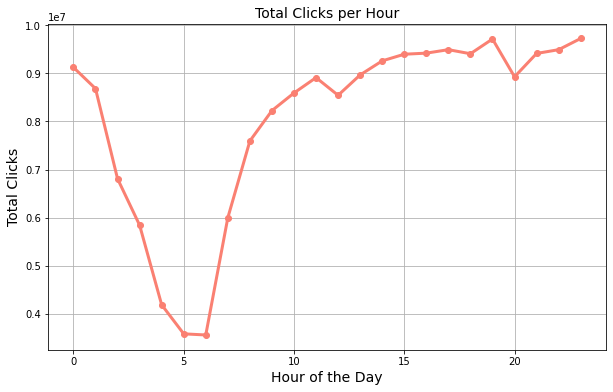

In [10]:
hourly_clicks = all_data.groupby('hour')['count'].sum()
plt.figure(figsize=(10, 6))
plt.plot(hourly_clicks.index, hourly_clicks.values, color='salmon', linewidth=3, marker='o')
plt.title('Total Clicks per Hour', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Total Clicks', fontsize=14)
plt.grid(True)
plt.show()

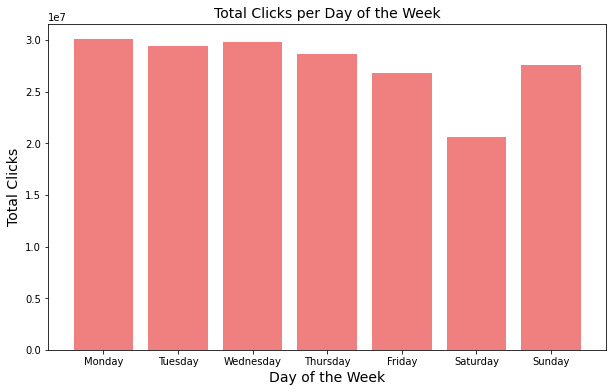

In [11]:
weekly_clicks = all_data.groupby('day_of_week')['count'].sum()
weekly_clicks = weekly_clicks.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10, 6))
plt.bar(weekly_clicks.index, weekly_clicks.values, color='lightcoral')
plt.title('Total Clicks per Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Total Clicks', fontsize=14)
plt.show()

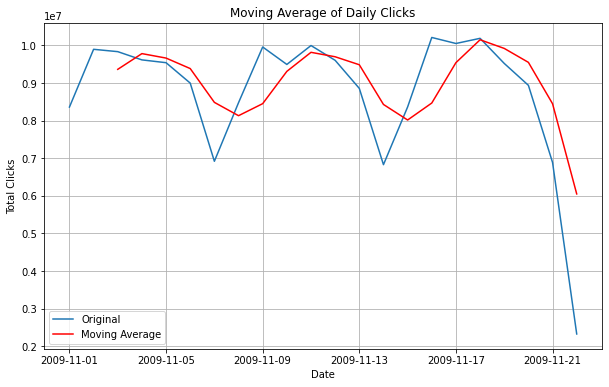

In [12]:
daily_clicks_ma = daily_clicks.rolling(window=3).mean()
plt.figure(figsize=(10, 6))
plt.plot(daily_clicks.index, daily_clicks.values, label='Original')
plt.plot(daily_clicks_ma.index, daily_clicks_ma.values, label='Moving Average', color='red')
plt.title('Moving Average of Daily Clicks')
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.legend()
plt.grid(True)
plt.show()

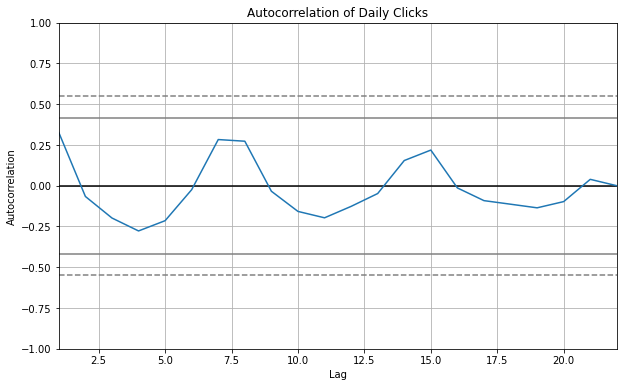

In [13]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(daily_clicks)
plt.title('Autocorrelation of Daily Clicks')
plt.show()

In [14]:
from scipy.stats import linregress

x = range(len(daily_clicks))
y = daily_clicks.values
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}, p-value: {p_value}")

Slope: -95845.8447204969, Intercept: 9773894.960474309, R-squared: 0.12141845878860162, p-value: 0.11200269239782339


In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('count ~ C(hour)', data=all_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq          df          F         PR(>F)
C(hour)   3.559739e+07        23.0  26.770348  2.332045e-115
Residual  1.102836e+12  19075440.0        NaN            NaN


In [16]:
# Aggregate total clicks per day
daily_clicks = all_data.groupby('date')['count'].sum().reset_index()

# Add the day of the week
daily_clicks['day_of_week'] = pd.to_datetime(daily_clicks['date']).dt.day_name()

# Perform ANOVA
model = ols('count ~ C(day_of_week)', data=daily_clicks).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                      sum_sq    df         F    PR(>F)
C(day_of_week)  3.887812e+13   6.0  3.456678  0.023904
Residual        2.811812e+13  15.0       NaN       NaN


In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=daily_clicks['count'], groups=daily_clicks['day_of_week'], alpha=0.05)
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1    group2     meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------------
  Friday    Monday  1091691.6667 0.9517 -2688043.9105 4871427.2438  False
  Friday  Saturday -2054151.6667 0.5452 -5833887.2438 1725583.9105  False
  Friday    Sunday    -2050593.0 0.4745 -5586211.8856 1485025.8856  False
  Friday  Thursday   624315.3333 0.9972 -3155420.2438 4404050.9105  False
  Friday   Tuesday      862593.0 0.9844 -2917142.5771 4642328.5771  False
  Friday Wednesday  1003075.3333 0.9674 -2776660.2438 4782810.9105  False
  Monday  Saturday -3145843.3333 0.1363 -6925578.9105  633892.2438  False
  Monday    Sunday -3142284.6667 0.0982 -6677903.5522  393334.2189  False
  Monday  Thursday  -467376.3333 0.9994 -4247111.9105 3312359.2438  False
  Monday   Tuesday  -229098.6667    1.0 -4008834.2438 3550636.9105  False
  Monday Wednesday   -88616.3333    1.

In [18]:
from scipy.stats import ttest_ind

weekdays = all_data[all_data['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekends = all_data[all_data['day_of_week'].isin(['Saturday', 'Sunday'])]
t_stat, p_val = ttest_ind(weekdays['count'], weekends['count'])
print(f"t-statistic: {t_stat}, p-value: {p_val}")

t-statistic: -9.863785515832552, p-value: 5.976072162748257e-23


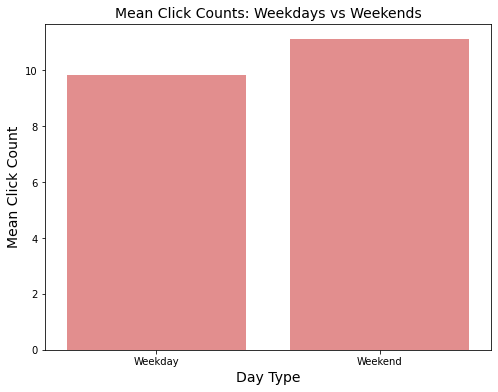

In [19]:
# Add a new column to indicate weekday or weekend
all_data['day_type'] = all_data['day_of_week'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'Weekend')

# Calculate mean click counts for weekdays and weekends
mean_clicks = all_data.groupby('day_type')['count'].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(data=mean_clicks, x='day_type', y='count', color='lightcoral')
plt.title('Mean Click Counts: Weekdays vs Weekends', fontsize=14)
plt.xlabel('Day Type', fontsize=14)
plt.ylabel('Mean Click Count', fontsize=14)
plt.show()

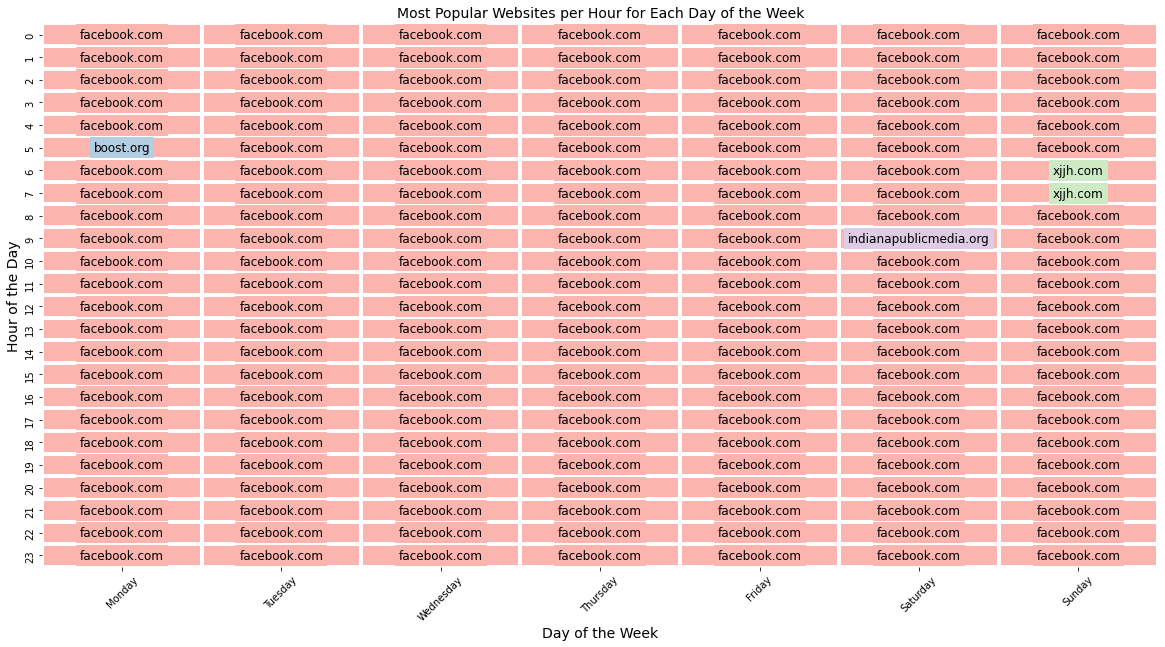

In [24]:
from matplotlib.colors import ListedColormap

# Aggregate click counts by hour, day of the week, and destination website
aggregated_data = all_data.groupby(['hour', 'day_of_week', 'to'])['count'].sum().reset_index()

# Identify the website with the maximum click count for each hour and day combination
max_clicks_per_hour_day = aggregated_data.loc[aggregated_data.groupby(['hour', 'day_of_week'])['count'].idxmax()]

# Create a pivot table for better visualization
pivot_table = max_clicks_per_hour_day.pivot(index='hour', columns='day_of_week', values='to')

# Ensure columns are ordered correctly
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Create a color mapping for websites
unique_websites = pd.unique(pivot_table.values.ravel())
colors = sns.color_palette("Pastel1", len(unique_websites))
color_mapping = {website: colors[i] for i, website in enumerate(unique_websites)}

# Create a custom colormap
custom_cmap = ListedColormap([color_mapping[website] for website in unique_websites if pd.notna(website)])

# Plot the results using text annotations
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table.isna(), cmap='Pastel1', cbar=False, linewidths=3.5)

# Annotate with the actual website names and color-code them
for i in range(pivot_table.shape[0]):
    for j in range(pivot_table.shape[1]):
        website = pivot_table.iloc[i, j]
        if pd.notna(website):
            plt.text(j + 0.5, i + 0.5, website, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor=color_mapping[website], edgecolor='none'))

plt.title('Most Popular Websites per Hour for Each Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Hour of the Day', fontsize=14)
plt.xticks(rotation=45)
plt.show()